### Example taken from *A Low-Complexity Quantum Principal Component Analysis Algorithm*
https://doi.org/10.1109/TQE.2021.3140152

In [364]:
import numpy as np
import itertools
from qiskit_experiments.library import StateTomography
from qiskit.visualization import plot_state_city,array_to_latex
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
from qiskit.circuit.library.standard_gates import RYGate
from qiskit import Aer, transpile, execute
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.algorithms.linear_solvers.matrices.numpy_matrix import NumPyMatrix
from qiskit.circuit.library import PhaseEstimation
import matplotlib.pyplot as plt
from qiskit import BasicAer, execute
import scipy as sc
import pandas as pd
from qiskit.circuit.library.data_preparation.state_preparation import *
#9329 con 6 res
#seed 10 con resolution 5
#6476 cambiando eigenvalues a 0.55 e 0.45 ris=7
# 12 con 4x4 matrix e risoluzione 7
#500  4x4 cambiando autovalori.
#4524
np.random.seed(9329)

example_matrix=np.random.rand(2,2)


example_matrix=np.dot(example_matrix,example_matrix.T)

sum_squares = (example_matrix**2).sum()
input_probabilities = (example_matrix**2/sum_squares).flatten()

print(input_probabilities)

[0.23882155 0.11761036 0.11761036 0.52595773]


In [365]:
example_matrix,np.linalg.eig(example_matrix)

(array([[0.74150918, 0.52035838],
        [0.52035838, 1.10041169]]),
 (array([0.37052824, 1.47139263]),
  array([[-0.8142539 , -0.58050891],
         [ 0.58050891, -0.8142539 ]])))

In [366]:
example_matrix1=example_matrix/np.trace(example_matrix)
example_matrix1,np.linalg.eig(example_matrix1)

(array([[0.40257385, 0.28250854],
        [0.28250854, 0.59742615]]),
 (array([0.20116404, 0.79883596]),
  array([[-0.8142539 , -0.58050891],
         [ 0.58050891, -0.8142539 ]])))

In [323]:
eig,e_v=np.linalg.eig(example_matrix1)
#b=np.array([.55,.45])
b=np.array([.6,.3,.07,0.03])
BB = e_v@np.diag(b)@e_v.T
BB, np.linalg.eig(BB)
example_matrix2=BB

sum_squares = (example_matrix2**2).sum()
input_probabilities = (example_matrix2**2/sum_squares).flatten()
example_matrix2=example_matrix2/np.trace(example_matrix2)
print(input_probabilities)

[0.13264575 0.05052016 0.02962622 0.04305508 0.05052016 0.13275186
 0.00022045 0.01429935 0.02962622 0.00022045 0.1859229  0.08495269
 0.04305508 0.01429935 0.08495269 0.10333162]


In [324]:
example_matrix2,np.linalg.eig(example_matrix2)

(array([[ 0.24588601,  0.15174679,  0.11620512,  0.14008749],
        [ 0.15174679,  0.24598434, -0.01002398,  0.08073192],
        [ 0.11620512, -0.01002398,  0.29110764,  0.19677763],
        [ 0.14008749,  0.08073192,  0.19677763,  0.21702201]]),
 (array([0.6 , 0.3 , 0.07, 0.03]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])))

In [367]:
np.trace(example_matrix)*np.linalg.eig(example_matrix1)[0]

array([0.37052824, 1.47139263])

In [368]:
#Tommaso's great code for computing the thetas
def thetas_computation(example_matrix):
    lst_combination=[]

    for k in range(1, int(np.ceil(np.log2(len(example_matrix)**2)))+1):
        lst_combination.append(list(map(list, itertools.product([0, 1], repeat=k))))
    container=[]
    for lst in lst_combination:
        container.append([''.join([''.join(str(j)) for j in i]) for i in lst])
    all_combinations=[item for c in container for item in c]

    general_bitstring=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=int(np.ceil(np.log2(len(example_matrix)**2))))))][:len(input_probabilities)]
    
    #Nodes contains all the values of the tree (except for the root)
    nodes=[]
    for st in all_combinations:
        #print(st)
        starts = [general_bitstring.index(l) for l in general_bitstring if l.startswith(st)]
        #print(starts)
        print(st,'->',np.sqrt(input_probabilities[starts].sum()))
        nodes.append(np.sqrt(input_probabilities[starts].sum()))
    
    #add root tree
    nodes.insert(0, 1)
    thetas=[]

    idx=0
    for i in range(1,len(nodes),2):
        
        right_node=i
        left_node=right_node+1
        if nodes[idx]!=0:
            thetas.append(2*np.arccos(nodes[right_node]/nodes[idx]))
            thetas.append(2*np.arcsin(nodes[left_node]/nodes[idx]))
        else:
            thetas.append(0)
            thetas.append(0)

        idx+=1
    return thetas, all_combinations

# SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# for idx,th in zip(all_combinations,thetas):
#     print('\u03F4(R{})'.format((str(idx).translate(SUB))),'->', th)
#thetas

In [369]:
def generate_qram_circuit(thetas, all_combinations):
    
    right_nodes_indexes=list(range(0,len(thetas),2))
    rotations_list=list(zip(np.array(all_combinations)[right_nodes_indexes],np.array(thetas)[right_nodes_indexes]))

    #qc=QuantumCircuit(len(example_matrix))
    qc=QuantumCircuit(int(np.ceil(np.log2(len(example_matrix)**2))))

    for r_l in rotations_list:
        target_qubit=len(r_l[0])-1
        
        #First case of R_0
        if target_qubit==0:
            qc.ry(theta=r_l[1],qubit=target_qubit)
            continue
            
        not_gate=[]
        for qb in range(target_qubit):
            if r_l[0][qb]=='0':
                not_gate.append(qb)
                
        c_t_qubits=list(range(len(r_l[0])))
        n_controls=len(range(target_qubit))
        
        if len(not_gate)>0:
            qc.x(not_gate)
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
            qc.x(not_gate)
        else:
            c_ry = RYGate(r_l[1]).control(n_controls)
            qc.append(c_ry, c_t_qubits)
    return qc

In [405]:
thetas, all_combinations = thetas_computation(example_matrix1)
matrix_circuit = generate_qram_circuit(thetas, all_combinations)
matrix_circuit.draw()

0 -> 0.5970191885526359
1 -> 0.8022269557300803
00 -> 0.4886937228241991
01 -> 0.34294366413781835
10 -> 0.34294366413781835
11 -> 0.7252294338536457


┌───────────┐┌───┐              ┌───┐              
q_0: ┤ Ry(1.862) ├┤ X ├──────■───────┤ X ├──────■───────
     └───────────┘└───┘┌─────┴──────┐└───┘┌─────┴──────┐
q_1: ──────────────────┤ Ry(1.2238) ├─────┤ Ry(2.2582) ├
                       └────────────┘     └────────────┘

In [406]:
#Check matrix encoding
backend = Aer.get_backend("statevector_simulator")
job = backend.run(transpile(matrix_circuit, backend=backend))
job.result().get_counts()

{'00': 0.238821554727775,
 '01': 0.117610356772273,
 '10': 0.117610356772273,
 '11': 0.525957731727679}

In [495]:
#Unitary for PE
resolution = 6
unitary_backend = Aer.get_backend("unitary_simulator")
u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)
unitary_job = unitary_backend.run(transpile(u_circuit, backend=unitary_backend))
unitary_job.result().get_unitary()

/var/folders/rr/g930v2cj1wvdzc257kclm3lm0000gn/T/ipykernel_1535/2943358390.py:4: DeprecationWarning: The NumPyMatrix class is deprecated as of Qiskit Terra 0.22.0 and will be removed no sooner than 3 months after the release date. 
  u_circuit = NumPyMatrix(example_matrix1, evolution_time=2*np.pi)


Operator([[ 3.02052887e-01+0.31079086j, -1.10365961e-16-0.90120647j],
          [-1.10365961e-16-0.90120647j,  3.02052887e-01-0.31079086j]],
         input_dims=(2,), output_dims=(2,))

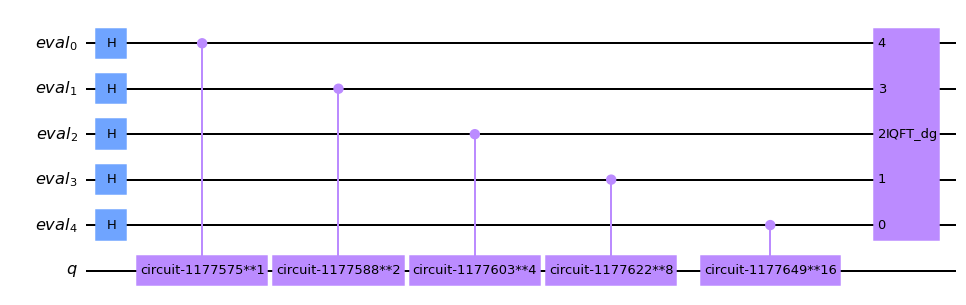

In [496]:
#PE circuit
pe = PhaseEstimation(resolution, u_circuit, name = "PE")
pe.decompose().draw("mpl")

# Check Statevector

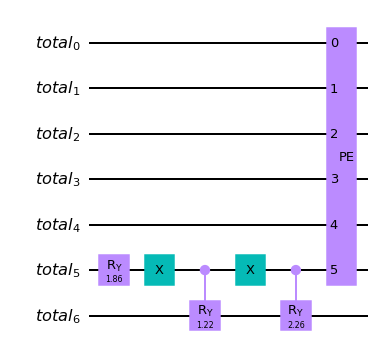

In [497]:
tot_qubit = resolution+len(example_matrix1)

qr_total_sim = QuantumRegister(tot_qubit, 'total')
# classical = ClassicalRegister(4, 'measure')

total_circuit_sim = QuantumCircuit(qr_total_sim , name='matrix')

total_circuit_sim.append(matrix_circuit.to_gate(), qr_total_sim[resolution:])
total_circuit_sim.append(pe.to_gate(), qr_total_sim[0:pe.num_qubits])
# total_circuit.measure(qr_total[:2], classical[:])
#total_circuit.swap(qr_total[0],qr_total[1])
#total_circuit.measure_all()

total_circuit_sim.decompose(reps=1).draw("mpl")

In [498]:
# Create the first operator for tomography
op_U=total_circuit_sim.to_gate(label='op_U').control()

In [499]:
backend_total = Aer.get_backend("statevector_simulator")
job = backend_total.run(transpile(total_circuit_sim, backend=backend_total))
statevector = np.asarray(job.result().get_statevector()).round(4)
#plot_histogram(counts)

/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/opt/miniconda3/envs/EAGLE_environment/lib/python3.8/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [500]:
def attach_bitstrings(vector):
    return list(zip(bitstrings, vector))

In [501]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
sim_statevector=attach_bitstrings(statevector)


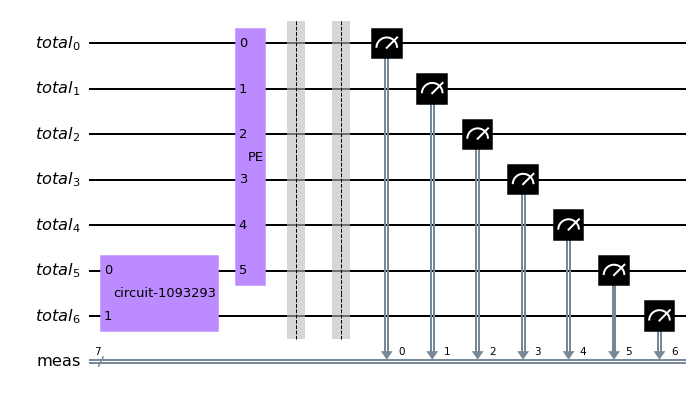

In [502]:
tot_qubit = resolution+len(example_matrix1)

qr_total = QuantumRegister(tot_qubit, 'total')

total_circuit = QuantumCircuit(qr_total , name='matrix')

total_circuit.append(matrix_circuit.to_gate(), qr_total[resolution:])
total_circuit.append(pe.to_gate(), qr_total[0:pe.num_qubits])
total_circuit.barrier()

total_circuit.measure_all()
total_circuit.draw("mpl")

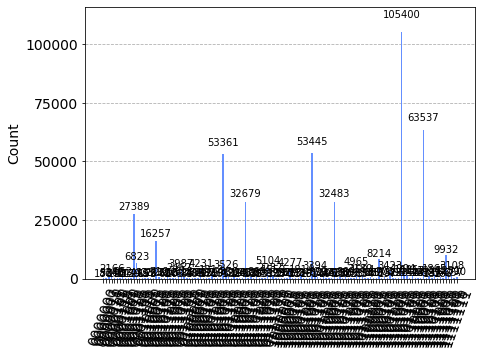

In [503]:
n_shots=500000
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit, backend=backend_total), shots=n_shots)
counts = job.result().get_counts()
plot_histogram(counts)

In [504]:
for i in counts:
    counts[i]/=n_shots
#counts

In [505]:
statevector=np.zeros(2**tot_qubit)
for i in counts:
    statevector[int(i,2)]=counts[i]
#statevector

In [506]:
#Create second operator tomography
op_V = StatePreparation(np.sqrt(statevector),label='c_V').control()

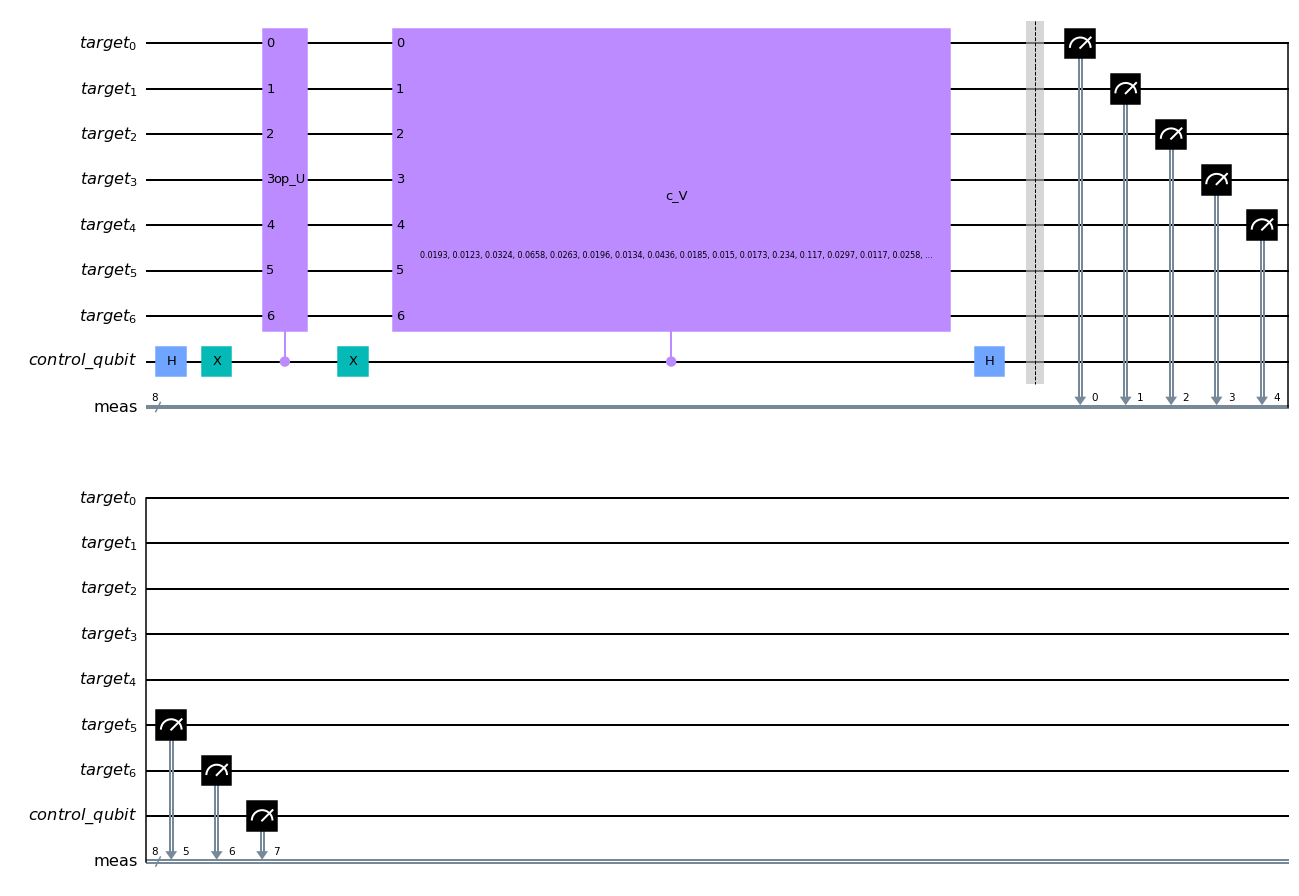

In [507]:

tot_qubit = resolution+len(example_matrix)

qr_total_xi = QuantumRegister(tot_qubit, 'target')
qr_control = QuantumRegister(1, 'control_qubit')

total_circuit_2 = QuantumCircuit(qr_total_xi,qr_control, name='matrix')
total_circuit_2.h(qr_control)
total_circuit_2.x(qr_control)
total_circuit_2.append(op_U, qr_control[:]+qr_total_xi[:])
total_circuit_2.x(qr_control)
total_circuit_2.append(op_V, qr_control[:]+qr_total_xi[:])
total_circuit_2.h(qr_control)
total_circuit_2.measure_all()
total_circuit_2.draw("mpl")

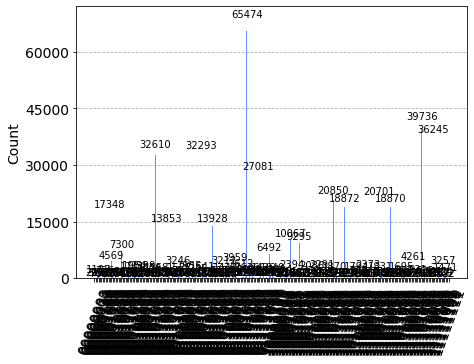

In [508]:
backend_total = Aer.get_backend("qasm_simulator")
job = backend_total.run(transpile(total_circuit_2, backend=backend_total), shots=n_shots)
counts_for_sign = job.result().get_counts()
plot_histogram(counts_for_sign)

In [509]:
#Take only counts with control qubits equal to 0
tmp=np.zeros(2**tot_qubit)
for c in counts_for_sign:
    if c[0]=='0':
        tmp[int(c[1:],2)]=counts_for_sign[c]
#tmp

In [510]:
###Metodo Nannicini
'''
tmp_=tmp/(sum(tmp))

sign_diff=[]
sign=[]
x_list=[]
for i in range(len(tmp_)):
    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))
    
    x_list.append(x)
    
    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))
    sign.append(np.sign(x))
    '''

'\ntmp_=tmp/(sum(tmp))\n\nsign_diff=[]\nsign=[]\nx_list=[]\nfor i in range(len(tmp_)):\n    x=(np.sqrt(statevector[i])*0.5)+(((statevector[i])/np.sqrt(statevector[i]))*0.5) - (tmp_[i]/(2*np.sqrt(statevector[i])))\n    \n    x_list.append(x)\n    \n    sign_diff.append(np.sign(x)+np.sign((sim_statevector[i][1].real)))\n    sign.append(np.sign(x))\n    '

In [511]:
#Sign estimation
sign_dictionary={}
sign=0
for e, (count, prob) in enumerate(zip(tmp, statevector)):
    if count>0.4*prob*n_shots:
        sign=1
    else:
        sign=-1
    if prob==0:
        sign=1
    sign_dictionary.update({bin(e)[2:].zfill(tot_qubit):sign})

In [512]:
statevector_dictionary={}
for e,key in enumerate(sign_dictionary):
    statevector_dictionary[key]=sign_dictionary[key]*np.sqrt(statevector[e])

#statevector_dictionary

In [513]:
bitstrings=[''.join([''.join(str(j)) for j in i]) for i in list(map(list, itertools.product([0, 1], repeat=resolution+len(example_matrix1))))]
ss=attach_bitstrings(statevector)
#ss

In [514]:
df=pd.DataFrame(ss)
#df['module']=df[1].apply(lambda x: x.real**2 + x.imag**2)
#df.set_index(0).module.plot(kind='bar')
df.columns=['state','module']
df

,state,module
0,0000000,0.000374
1,0000001,0.000152
2,0000010,0.001052
3,0000011,0.004332
4,0000100,0.000692
...,...,...
123,1111011,0.019864
124,1111100,0.002462
125,1111101,0.006216
126,1111110,0.000514


In [515]:
df['lambda']=df['state'].apply(lambda x: x[-resolution:])
df1=df.groupby('lambda').agg({'module':'sum'})
#df1['module_new']=df1['module'].apply(lambda x: np.sqrt(x.real**2 + x.imag**2))
df1=df1.sort_values('module')
df1

,module
lambda,
10110,0.001042
11010,0.001118
00110,0.001138
01110,0.001196
11110,0.001306
01010,0.001398
00001,0.001440
10001,0.001656
01000,0.001858


In [516]:
lambdas=df1.tail(len(example_matrix1)).index.values

In [517]:
lambdas

array(['10011', '01011'], dtype=object)

In [518]:
df.columns=['state','module','lambda']
df

,state,module,lambda
0,0000000,0.000374,00000
1,0000001,0.000152,00001
2,0000010,0.001052,00010
3,0000011,0.004332,00011
4,0000100,0.000692,00100
...,...,...,...
123,1111011,0.019864,11011
124,1111100,0.002462,11100
125,1111101,0.006216,11101
126,1111110,0.000514,11110


In [519]:
df['sign']=np.array(list(sign_dictionary.values()))
#df['sign']=np.array(sign)
df

,state,module,lambda,sign
0,0000000,0.000374,00000,1
1,0000001,0.000152,00001,1
2,0000010,0.001052,00010,1
3,0000011,0.004332,00011,1
4,0000100,0.000692,00100,1
...,...,...,...,...
123,1111011,0.019864,11011,1
124,1111100,0.002462,11100,1
125,1111101,0.006216,11101,1
126,1111110,0.000514,11110,1


In [520]:
df['module']=df['module'].multiply(np.array(list(sign_dictionary.values())), axis=0)
#df['module']=df['module'].multiply(np.array(sign), axis=0)
df=df.fillna(0)
df

,state,module,lambda,sign
0,0000000,0.000374,00000,1
1,0000001,0.000152,00001,1
2,0000010,0.001052,00010,1
3,0000011,0.004332,00011,1
4,0000100,0.000692,00100,1
...,...,...,...,...
123,1111011,0.019864,11011,1
124,1111100,0.002462,11100,1
125,1111101,0.006216,11101,1
126,1111110,0.000514,11110,1


In [521]:
a=[]
save_sign=[]
eigenvalues=[]
for l in lambdas:
    eigenvalues.append(int(l[::-1],base=2)/(2**resolution))
    a_=np.array(df.query("state.str.endswith(@l)")['module'].values)
    #print(a_)
    save_sign.append(np.sign(a_))
    #print(save_sign)
    
    a.append(np.sqrt(abs(a_)))

#a=[a1,a2]

for i in range(len(a)):
    print(a[i])
    normalization_factor=np.sqrt((1/(sum(a[i]**2))))
    print(normalization_factor)
    a[i]*=normalization_factor
    a[i]*=save_sign[i]
    
    print(a)

[0.18031639 0.25565211 0.25488429 0.3564744 ]
1.8572351905589612
[array([0.33488994, 0.47480609, 0.47338007, 0.66205681]), array([0.234047  , 0.32668333, 0.32694036, 0.45912961])]
[0.234047   0.32668333 0.32694036 0.45912961]
1.4445950647080084
[array([0.33488994, 0.47480609, 0.47338007, 0.66205681]), array([0.33810315, 0.47192513, 0.47229643, 0.66325637])]


In [522]:
eigenvalues

[0.78125, 0.8125]

In [523]:
#TODO: Capire se fare la media tra i vari fattori di rescaling
eigenvectors=[]
for ll, eig in zip(a,eigenvalues):
    
    eigenvector=np.zeros(len(example_matrix1)) #put length of eigenvector
    save_sign=np.sign(ll)
    sv=abs(ll)
    max_list=[]
    scaled_statevectors=[]
    for e,i in enumerate(range(0,len(sv),len(example_matrix1))):
        max_list.append(max(sv[i:i+len(example_matrix1)]))
        scaled_statevectors.append(sv[i:i+len(example_matrix1)]/max_list[e])
        #print(max_list,scaled_statevectors)
    idx_max=np.argmax(max_list)
    #print(idx_max)
    max_max=max_list[idx_max]
    #print(max_max)
    value=np.sqrt(max_max)
    #eigenvector=scaled_statevectors[idx_max]*value*save_sign[:len(example_matrix)]
    eigenvector=scaled_statevectors[idx_max]*value*save_sign[len(example_matrix1)*idx_max:len(example_matrix1)*idx_max+len(example_matrix1)]
    eigenvectors.append((eig,eigenvector))
    print('reconstructed_eigenvector:',eigenvector)
    print('reconstructed_eigenvalue:', eig)
    

reconstructed_eigenvector: [0.58178476 0.81366873]
reconstructed_eigenvalue: 0.78125
reconstructed_eigenvector: [0.57992783 0.81440553]
reconstructed_eigenvalue: 0.8125


In [436]:
np.linalg.eig(example_matrix1),np.linalg.eig(example_matrix2)

((array([0.20116404, 0.79883596]),
  array([[-0.8142539 , -0.58050891],
         [ 0.58050891, -0.8142539 ]])),
 (array([0.6 , 0.3 , 0.07, 0.03]),
  array([[-0.54010974, -0.31079311, -0.76691778,  0.15338266],
         [-0.34101425, -0.72369209,  0.45528741, -0.39075876],
         [-0.54078131,  0.59128095,  0.021657  , -0.59789078],
         [-0.54730826,  0.17339042,  0.45175377,  0.68286746]])))

In [126]:
1/(2**6)+1/(2**7)

0.0234375